<a href="https://colab.research.google.com/github/vinit6085903/anpr/blob/main/Dog_Cat_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import os

API_KEY = "52854155-0c17c21638c360c3d41a4aab2"

categories = ["cat", "dog"]
images_per_class = 200

for query in categories:

    save_folder = f"dataset/{query}"
    os.makedirs(save_folder, exist_ok=True)

    url = f"https://pixabay.com/api/?key={API_KEY}&q={query}&image_type=photo&per_page={images_per_class}"

    response = requests.get(url)
    data = response.json()

    for i, hit in enumerate(data["hits"]):
        img_url = hit["largeImageURL"]
        img_data = requests.get(img_url).content

        with open(f"{save_folder}/{query}_{i}.jpg", "wb") as f:
            f.write(img_data)

    print(f"{query} images downloaded")

print("Cat–Dog dataset ready!")


cat images downloaded
dog images downloaded
Cat–Dog dataset ready!


Text(0.5, 1.0, 'CAT IMAGE')

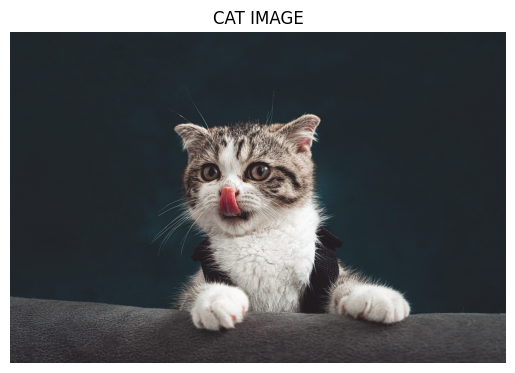

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
cat_path = "/content/dataset/cat"
img_name = os.listdir(cat_path)[0]
img = Image.open(os.path.join(cat_path, img_name))
plt.imshow(img)
plt.axis("off")
plt.title("CAT IMAGE")


Text(0.5, 1.0, 'DOG IMAGE')

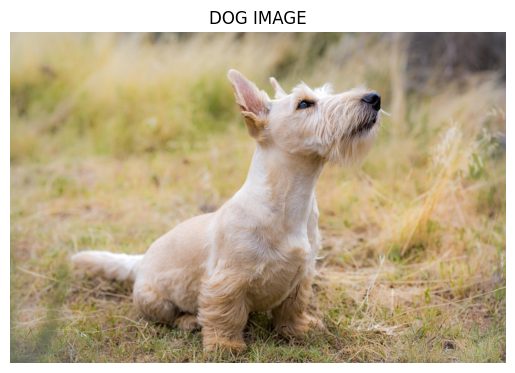

In [3]:
dog_path = "/content/dataset/dog"
img_name = os.listdir(dog_path)[0]
img = Image.open(os.path.join(dog_path, img_name))
plt.imshow(img)
plt.axis("off")
plt.title("DOG IMAGE")


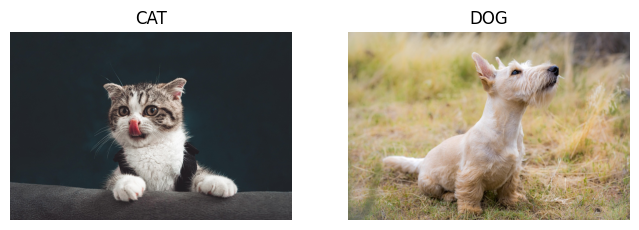

In [4]:
cat_img = os.listdir("/content/dataset/cat")[0]
dog_img = os.listdir("/content/dataset/dog")[0]
cat = Image.open(f"/content/dataset/cat/{cat_img}")
dog = Image.open(f"/content/dataset/dog/{dog_img}")
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cat)
plt.title("CAT")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(dog)
plt.title("DOG")
plt.axis("off")
plt.show()


In [5]:
import os
import shutil
import random

source_dir = '/content/dataset'
train_dir = os.path.join(source_dir, 'train')
val_dir = os.path.join(source_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

split_ratio = 0.8  # 80% for training, 20% for validation

for category in ['cat', 'dog']:
    category_source_path = os.path.join(source_dir, category)
    category_train_path = os.path.join(train_dir, category)
    category_val_path = os.path.join(val_dir, category)

    os.makedirs(category_train_path, exist_ok=True)
    os.makedirs(category_val_path, exist_ok=True)

    images = os.listdir(category_source_path)
    random.shuffle(images)

    num_train_images = int(len(images) * split_ratio)
    train_images = images[:num_train_images]
    val_images = images[num_train_images:]

    for img_name in train_images:
        src_path = os.path.join(category_source_path, img_name)
        dst_path = os.path.join(category_train_path, img_name)
        shutil.copy(src_path, dst_path)

    for img_name in val_images:
        src_path = os.path.join(category_source_path, img_name)
        dst_path = os.path.join(category_val_path, img_name)
        shutil.copy(src_path, dst_path)

print("Dataset split into training and validation sets.")

Dataset split into training and validation sets.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "/content/dataset/train", # Updated path
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

val_data = val_gen.flow_from_directory(
    "/content/dataset/val",   # Updated path
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

print("Image data generators created successfully.")

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Image data generators created successfully.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False  # IMPORTANT

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,286,401 (39.24 MB)

 Trainable params: 8,028,417 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6653 - loss: 0.9898 - val_accuracy: 0.9250 - val_loss: 0.1629
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9165 - loss: 0.2145 - val_accuracy: 0.9375 - val_loss: 0.1813
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9252 - loss: 0.1889 - val_accuracy: 0.9500 - val_loss: 0.1336
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9475 - loss: 0.1950 - val_accuracy: 0.9375 - val_loss: 0.1404
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9541 - loss: 0.1045 - val_accuracy: 0.9375 - val_loss: 0.1596
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9642 - loss: 0.1029 - val_accuracy: 0.9375 - val_loss: 0.1395
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9947 - loss: 0.0342 - val_accuracy: 0.9375 - val_loss: 0.1675
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9723 - loss: 0.0958 - val_accuracy: 0.9750 - val_loss:

In [10]:
loss, accuracy = model.evaluate(val_data)

print("Validation Accuracy:", accuracy)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 806ms/step - accuracy: 0.9594 - loss: 0.1051
Validation Accuracy: 0.949999988079071


In [11]:
import numpy as np


y_pred_prob = model.predict(val_data)


y_pred = (y_pred_prob > 0.5).astype(int).ravel()


y_true = val_data.classes


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


In [12]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Cat", "Dog"]
    )
)


              precision    recall  f1-score   support

         Cat       0.45      0.50      0.48        40
         Dog       0.44      0.40      0.42        40

    accuracy                           0.45        80
   macro avg       0.45      0.45      0.45        80
weighted avg       0.45      0.45      0.45        80



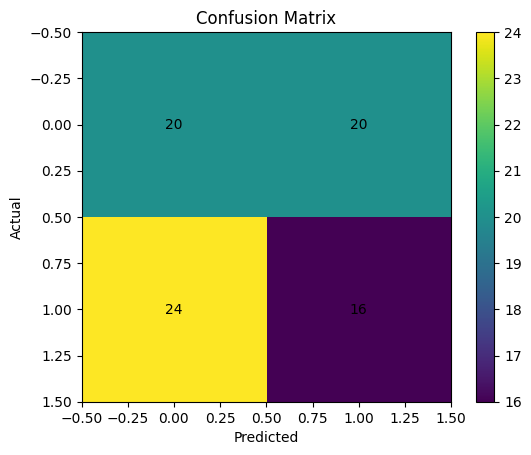

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


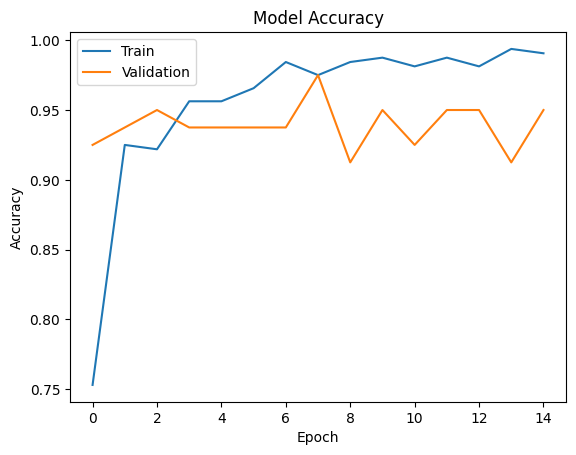

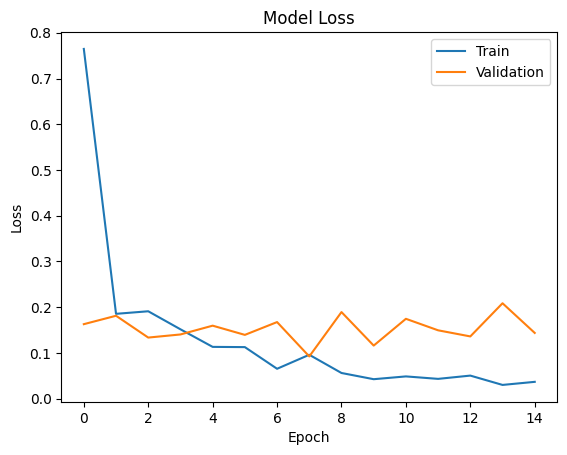

In [14]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()


In [15]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Train Loss:", train_loss)
print("Validation Loss:", val_loss)

if train_acc < 0.7 and val_acc < 0.7:
    print(" UNDERFITTING detected")
elif train_acc > 0.85 and val_acc < 0.7:
    print(" OVERFITTING detected")
else:
    print(" Model is well fitted")


Train Accuracy: 0.9906250238418579
Validation Accuracy: 0.949999988079071
Train Loss: 0.0367995910346508
Validation Loss: 0.143739253282547
 Model is well fitted


In [16]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img_show = image.load_img(img_path)
    plt.imshow(img_show)
    plt.axis("off")

    img = image.load_img(img_path, target_size=(224,224))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0][0]

    if pred > 0.5:
        label = "DOG"
        confidence = pred * 100
    else:
        label = "CAT"
        confidence = (1 - pred) * 100

    plt.title(f"{label} | Confidence: {confidence:.2f}%")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


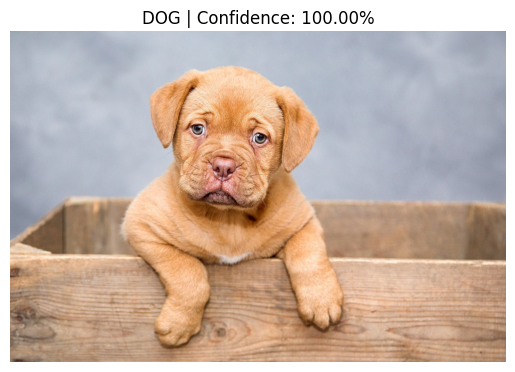

In [17]:

predict_image("/content/dataset/dog/dog_0.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


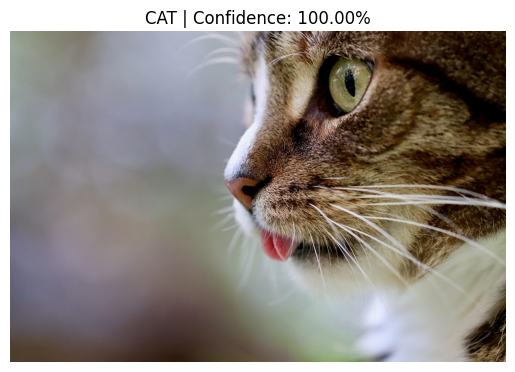

In [18]:
predict_image("/content/dataset/cat/cat_0.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


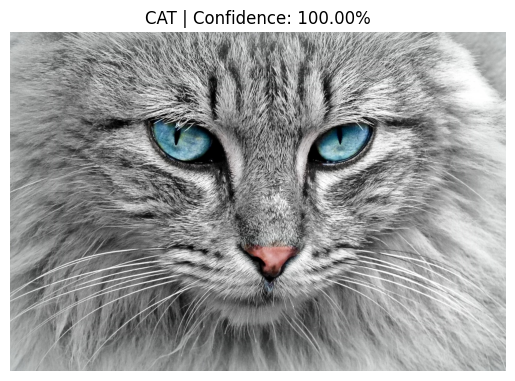

In [19]:
predict_image("/content/dataset/cat/cat_1.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


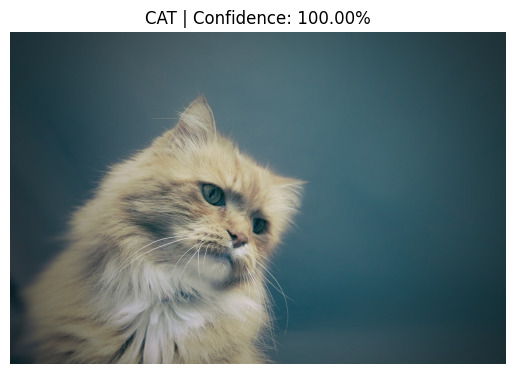

In [20]:
predict_image("/content/dataset/cat/cat_105.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


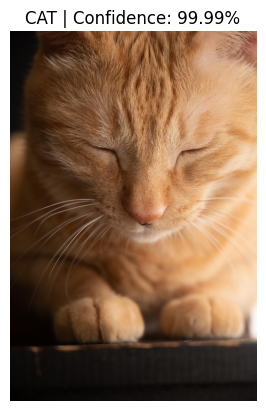

In [21]:
predict_image("/content/dataset/cat/cat_106.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


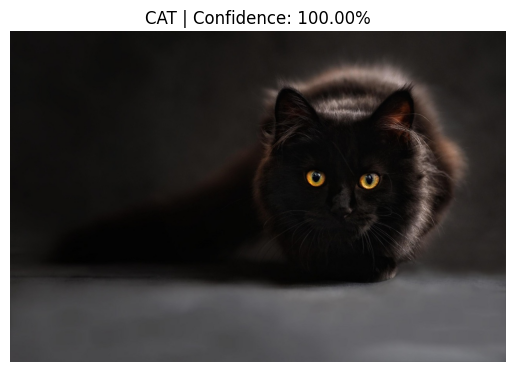

In [22]:
predict_image("/content/dataset/cat/cat_121.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


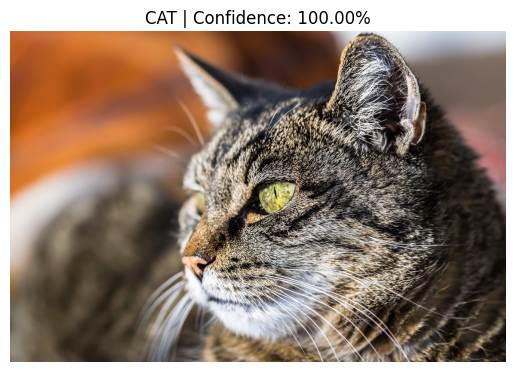

In [23]:
predict_image("/content/dataset/cat/cat_99.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


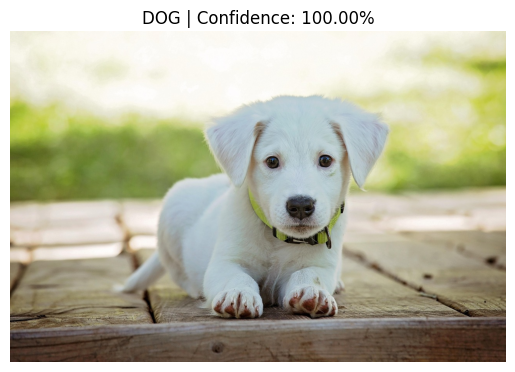

In [24]:

predict_image("/content/dataset/dog/dog_1.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


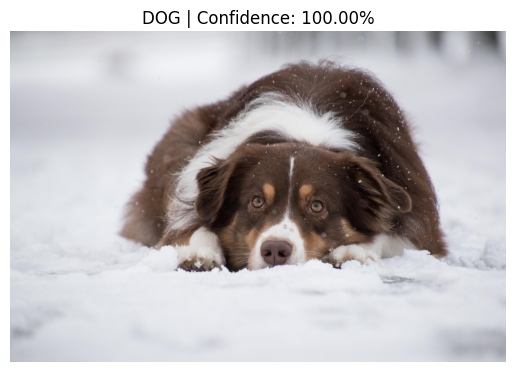

In [25]:

predict_image("/content/dataset/dog/dog_101.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


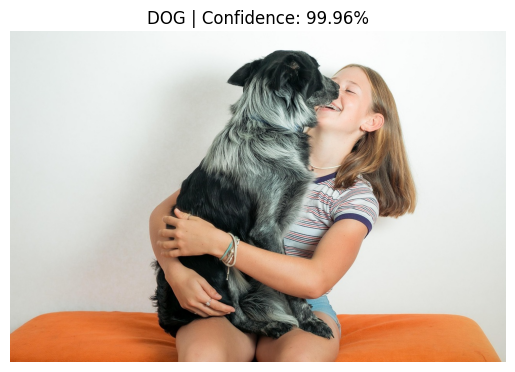

In [26]:

predict_image("/content/dataset/dog/dog_107.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


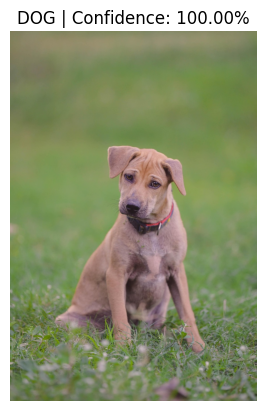

In [27]:

predict_image("/content/dataset/dog/dog_178.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


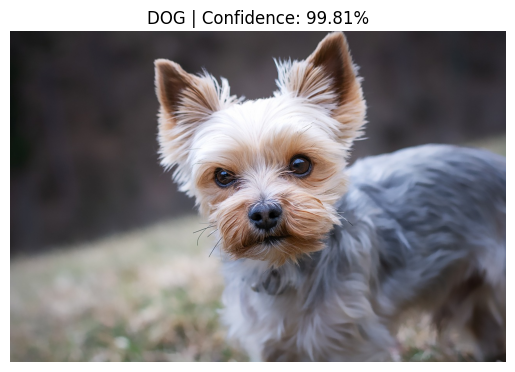

In [28]:

predict_image("/content/dataset/dog/dog_22.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


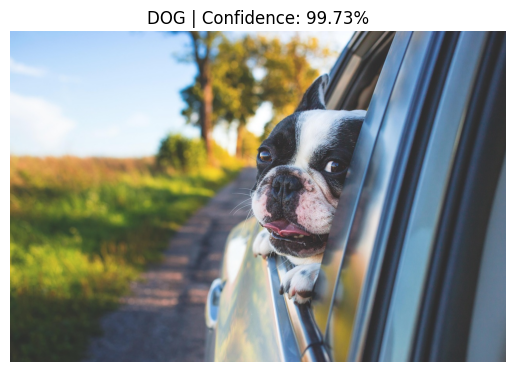

In [29]:

predict_image("/content/dataset/dog/dog_99.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


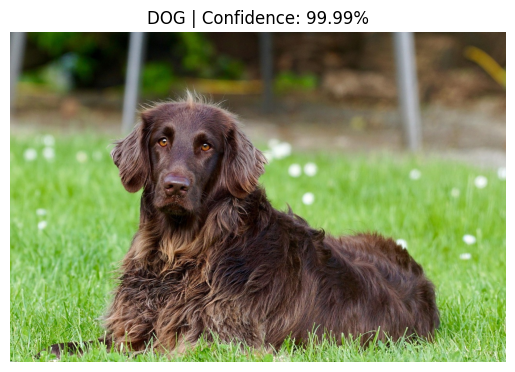

In [31]:

predict_image("/content/dataset/dog/dog_9.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


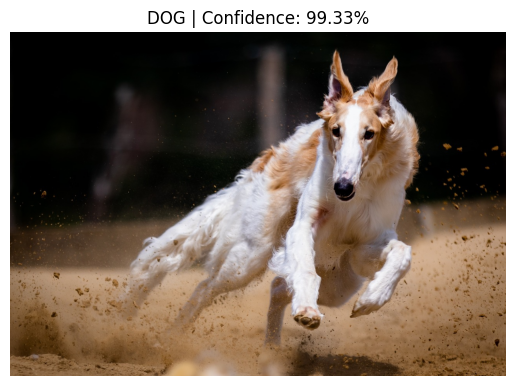

In [32]:

predict_image("/content/dataset/dog/dog_90.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


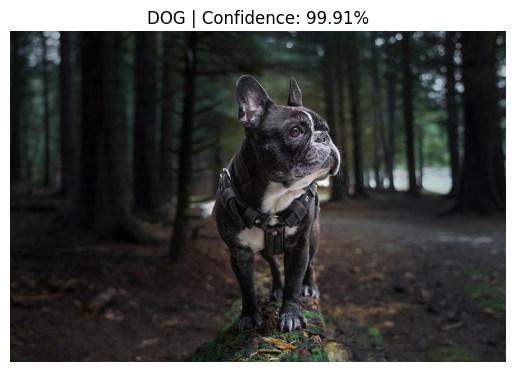

In [33]:

predict_image("/content/dataset/dog/dog_88.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


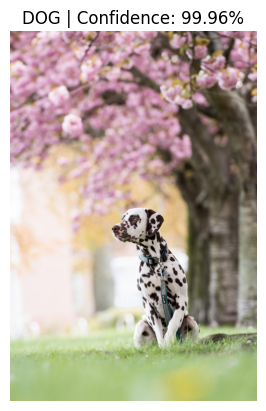

In [34]:

predict_image("/content/dataset/dog/dog_85.jpg", model)
